In [1]:
import fiftyone as fo
import fiftyone.zoo as foz

# List available zoo datasets
print(foz.list_zoo_datasets())

#
# Load the COCO-2017 validation split into a FiftyOne dataset
#
# This will download the dataset from the web, if necessary
#
dataset = foz.load_zoo_dataset("coco-2017", split="validation",dataset_dir="/data1/zhengshuaijie/coco-2017")

# Give the dataset a new name, and make it persistent so that you can
# work with it in future sessions
dataset.name = "coco-2017-validation-example2"
dataset.persistent = True



['activitynet-100', 'activitynet-200', 'bdd100k', 'caltech101', 'caltech256', 'cifar10', 'cifar100', 'cityscapes', 'coco-2014', 'coco-2017', 'fashion-mnist', 'fiw', 'hmdb51', 'imagenet-2012', 'imagenet-sample', 'kinetics-400', 'kinetics-600', 'kinetics-700', 'kinetics-700-2020', 'kitti', 'kitti-multiview', 'lfw', 'mnist', 'open-images-v6', 'open-images-v7', 'quickstart', 'quickstart-geo', 'quickstart-groups', 'quickstart-video', 'sama-coco', 'ucf101', 'voc-2007', 'voc-2012']
Found annotations at '/data1/zhengshuaijie/coco-2017/raw/instances_val2017.json'
Images already downloaded
Existing download of split 'validation' is sufficient
Loading 'coco-2017' split 'validation'
 100% |███████████████| 5000/5000 [36.7s elapsed, 0s remaining, 126.5 samples/s]      
Dataset 'coco-2017-validation' created


In [2]:
# Print some information about the dataset
print(dataset)

Name:        coco-2017-validation-example2
Media type:  image
Num samples: 5000
Persistent:  True
Tags:        []
Sample fields:
    id:           fiftyone.core.fields.ObjectIdField
    filepath:     fiftyone.core.fields.StringField
    tags:         fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    ground_truth: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)



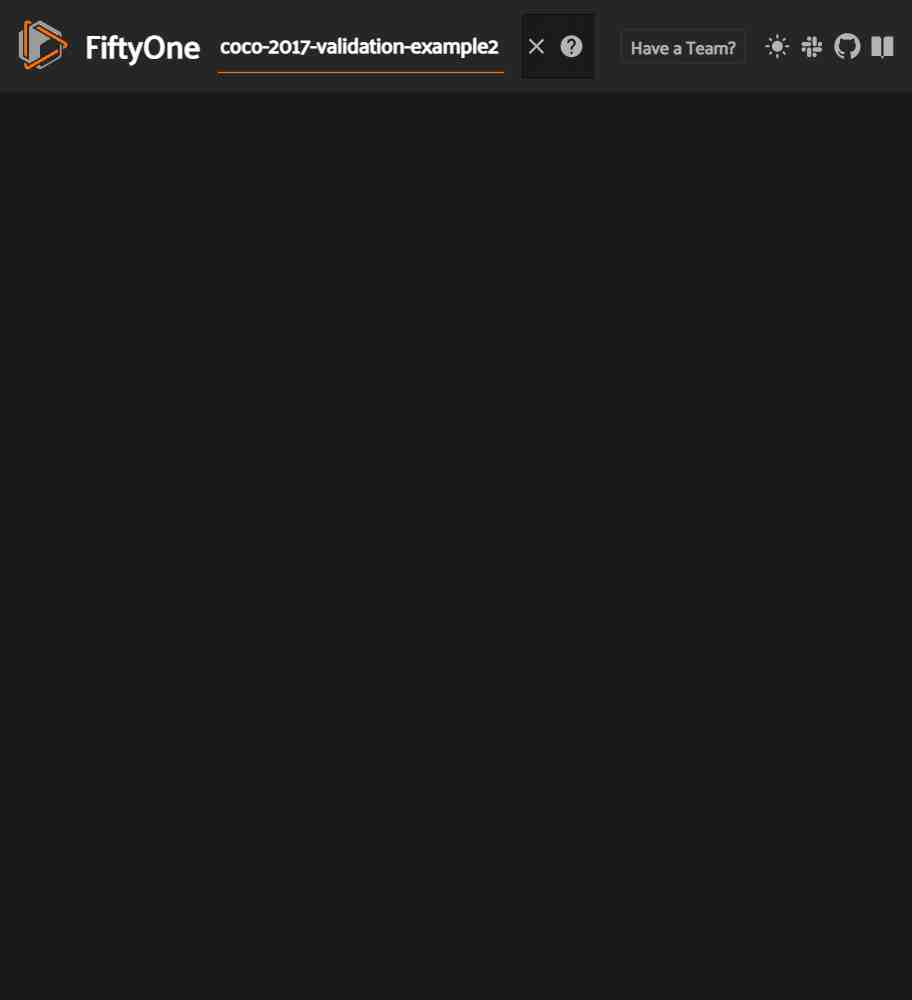

In [3]:
# Visualize the in the App
session = fo.launch_app(dataset)

In [4]:
import torch
import torchvision

# Run the model on GPU if it is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load a pre-trained Faster R-CNN model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.to(device)
model.eval()

print("Model ready")

/home/zhengshuaijie/miniconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/zhengshuaijie/miniconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /home/zhengshuaijie/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:05<00:00, 31.5MB/s] 


Model ready


In [5]:
# Choose a random subset of 100 samples to add predictions to
predictions_view = dataset.take(100, seed=51)

In [9]:
from PIL import Image
from torchvision.transforms import functional as func

import fiftyone as fo

# Get class list
classes = dataset.default_classes

# Add predictions to samples
with fo.ProgressBar() as pb:
    for sample in pb(predictions_view):
        # Load image
        image = Image.open(sample.filepath)
        image = func.to_tensor(image).to(device)
        c, h, w = image.shape

        # Perform inference
        preds = model([image])[0]
        labels = preds["labels"].cpu().detach().numpy()
        scores = preds["scores"].cpu().detach().numpy()
        boxes = preds["boxes"].cpu().detach().numpy()

        # Convert detections to FiftyOne format
        detections = []
        for label, score, box in zip(labels, scores, boxes):
            # Convert to [top-left-x, top-left-y, width, height]
            # in relative coordinates in [0, 1] x [0, 1]
            x1, y1, x2, y2 = box
            rel_box = [x1 / w, y1 / h, (x2 - x1) / w, (y2 - y1) / h]

            detections.append(
                fo.Detection(
                    label=classes[label],
                    bounding_box=rel_box,
                    confidence=score
                )
            )

        # Save predictions to dataset
        sample["faster_rcnn"] = fo.Detections(detections=detections)
        sample.save()

print("Finished adding predictions")

 100% |█████████████████| 100/100 [9.5s elapsed, 0s remaining, 9.4 samples/s]       
Finished adding predictions


In [10]:
session.view = predictions_view


Could not connect session, trying again in 10 seconds


Could not connect session, trying again in 10 seconds

